<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Дамми-модель" data-toc-modified-id="Дамми-модель-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Дамми-модель</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Аггрегатор такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Подготовка

Начнем с фундаментальных заявлений

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from catboost import cv, Pool

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

Загрузим данные

In [2]:
df = pd.read_csv('', index_col=[0], parse_dates=[0])

Пристально сверлим их взглядом

In [3]:
display(df.head())
display(df.tail())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные за 2018 год, начинаются мартом, заканчиваются августом. Пропусков нет. Ресемплируем по часу и аггрегруем по сумме, т.к. данные здесь даны с десятиминутным интервалом.

In [4]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Восхитительно!

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ

Визуализируем временной ряд

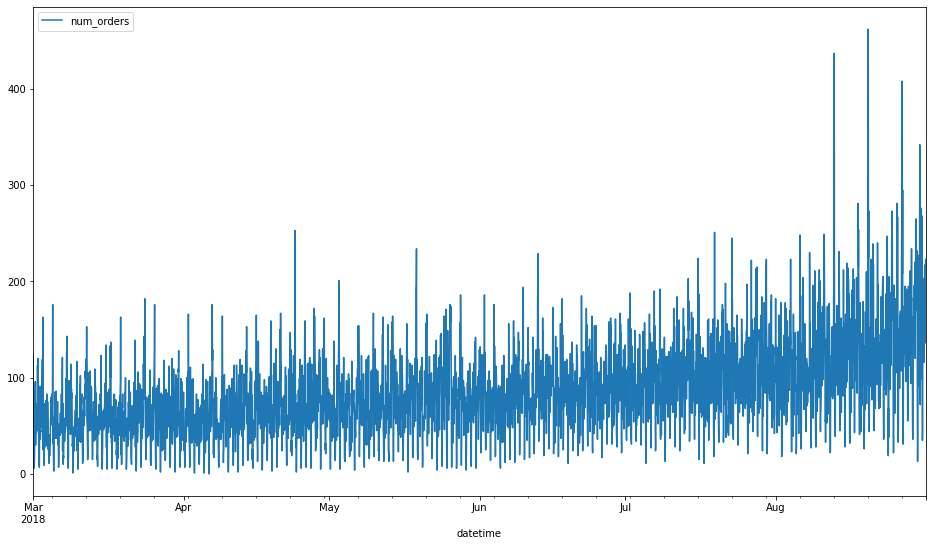

In [5]:
df.plot(figsize=(16,9));

получается довольно плотно. Попробуем посмотреть на скользящее среднее с размером окна равным, одним суткам.

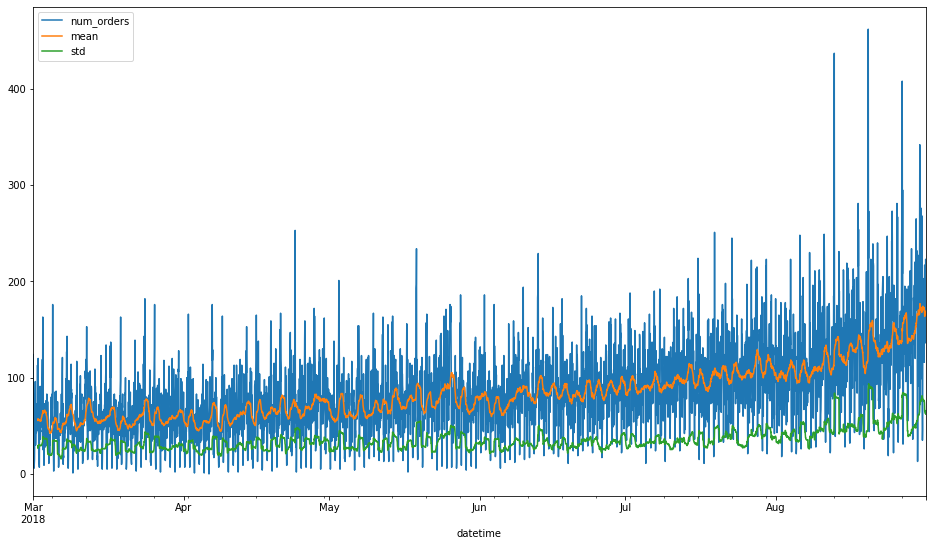

In [6]:
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()

df.plot(figsize=(16,9));

Посмотрим на июль

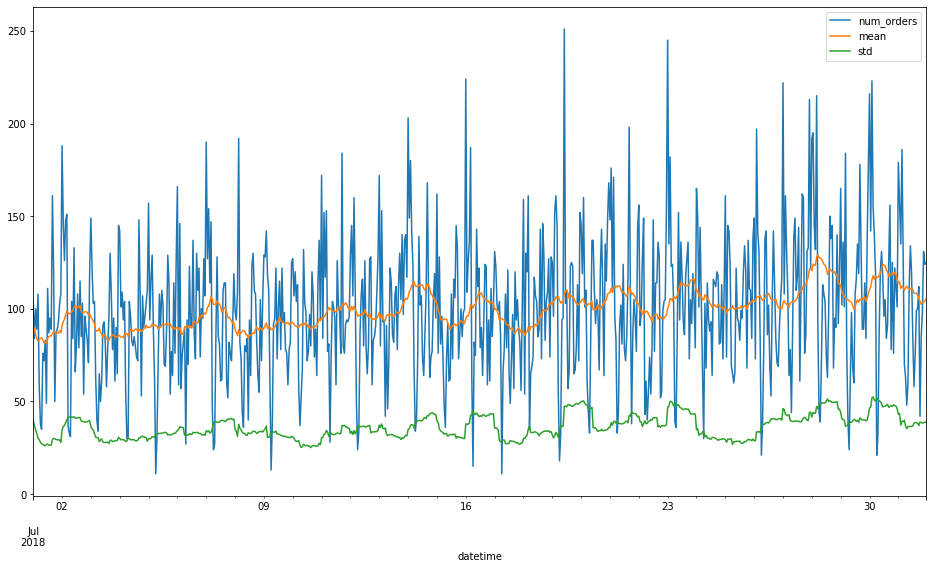

In [7]:
df['2018-07-01':'2018-07-31'].plot(figsize=(16,9));

Здесь, очевидно, есть суточные и недельные циклы. Декомпозируем и посмотрим, есть ли тренд или сезонность.

In [8]:
decomposed = seasonal_decompose(df['num_orders']) 

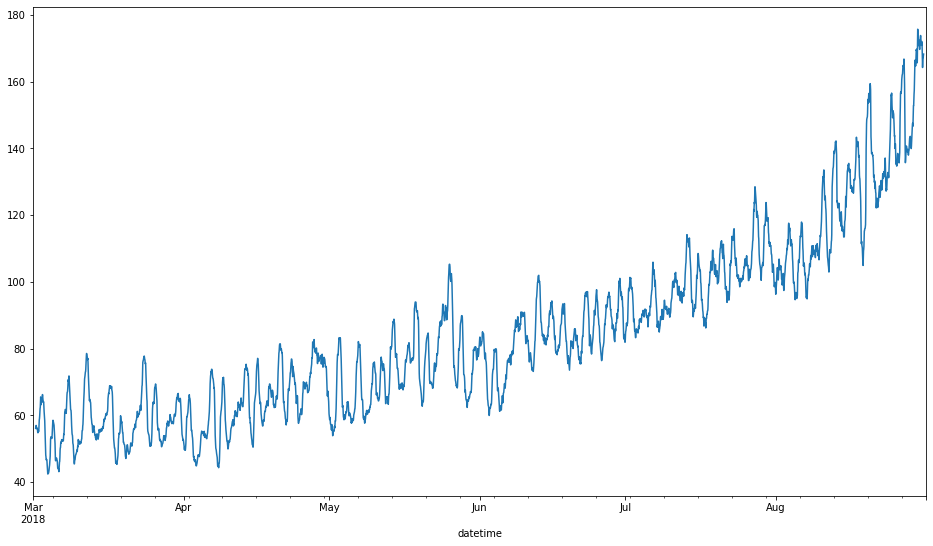

In [9]:
decomposed.trend.plot(figsize=(16,9));

Очевидный тренд на увеличение среднего количества заказов в час. А что с сезонностью?

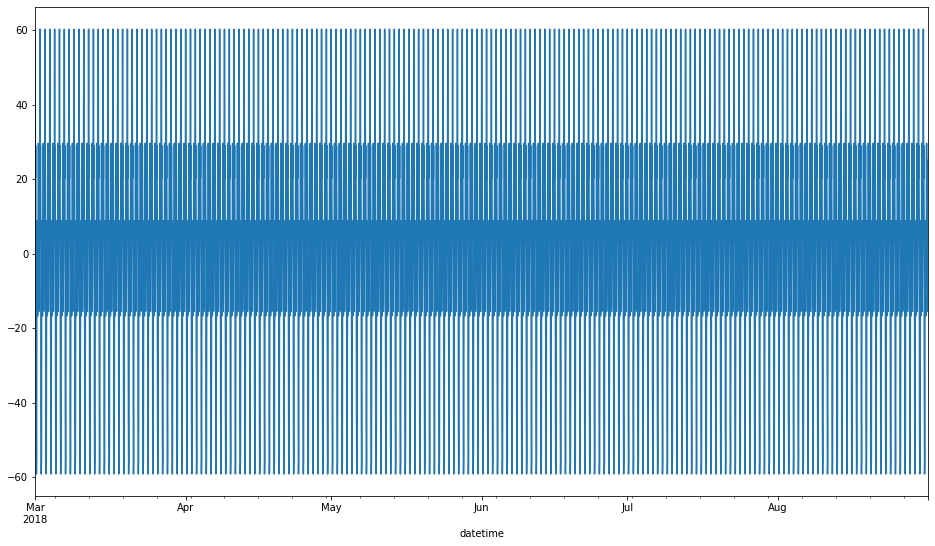

In [10]:
decomposed.seasonal.plot(figsize=(16,9));

Сплошная боль для глаз. Посмотрим на более короткий интервал, скажем, неделю.

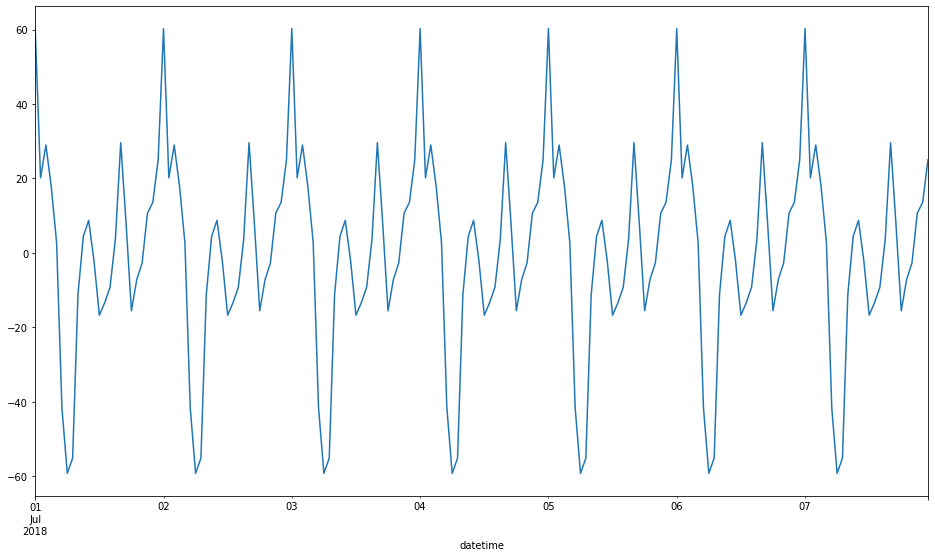

In [11]:
decomposed.seasonal['2018-07-01':'2018-07-07'].plot(figsize=(16,9));

Здесь имеем дело с суточой сезонностью. Посмотрим на шум!

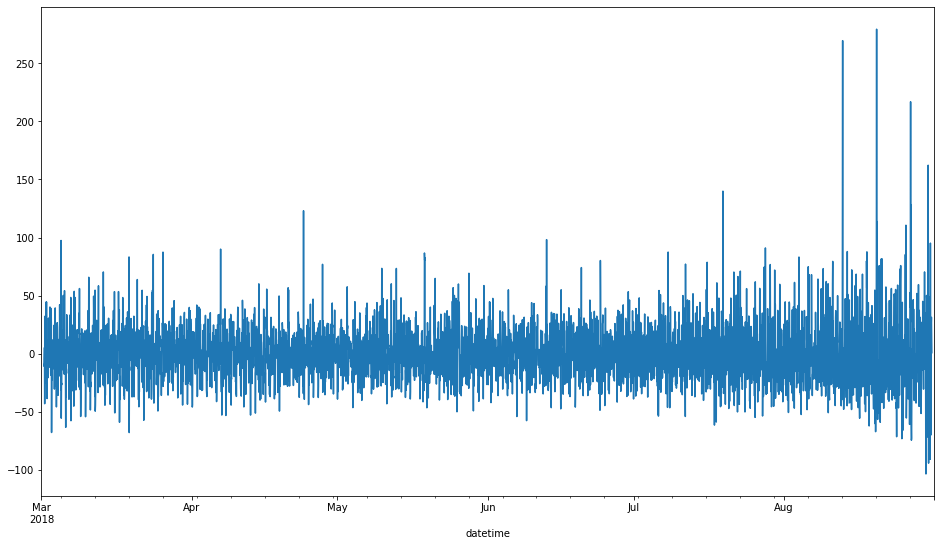

In [12]:
decomposed.resid.plot(figsize=(16,9));

Шум как шум

**Итак, что мы в итоге имеем:**
* повышение количества заказов к концу изучаемого периода;
* имеется суточная сезонность;
* есть еженедельные всплески.

**Что нам нужно сделать с данными:**
* добавить столбцы с месяцем, днем недели, днем месяца, часом;
* добавить столбец со скользящим средним, предлагаю, суточным;
* добавить столбцы с отстающими значениями, например, до недели.

Добавим признаков!

In [13]:
# напишем функцию по созданию нового датафрейма с дополнительными признаками
def feature_maker(df, max_lag, roll):
    advanced_df = df.copy()
    advanced_df['month'] = advanced_df.index.month
    advanced_df['day_of_week'] = advanced_df.index.dayofweek
    advanced_df['day'] = advanced_df.index.day
    advanced_df['hour'] = advanced_df.index.hour
    
    for lag in range(1, max_lag + 1):
        advanced_df['lag_{}'.format(lag)] = advanced_df['num_orders'].shift(lag)

    advanced_df['rolling_mean'] = advanced_df['num_orders'].shift().rolling(24).mean()
    
    return advanced_df

In [14]:
# применим функцию
advanced_df = feature_maker(df, 24*7, 24)
advanced_df.head()

,num_orders,mean,std,month,day_of_week,day,hour,lag_1,lag_2,lag_3,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,3,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,3,1,1,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,3,1,2,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,1,3,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,3,1,4,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поделим на выборки, уберем лишнее

In [15]:
train, test = train_test_split(advanced_df, shuffle=False, test_size=0.1)
train = train.dropna()

train_X = train.drop(['num_orders', 'mean', 'std'], axis=1)
train_y = train['num_orders']

test_X = test.drop(['num_orders', 'mean', 'std'], axis=1)
test_y = test['num_orders']

In [16]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((3806, 173), (3806,), (442, 173), (442,))

Ну все, можно на подиум!

## Обучение

Рассмотрим три модели:
* LinearRegression;
* RandomForestRegressor;
* CatBoostRegressor.

На адекватность проверим дамми-моделью.

### Линейная регрессия

Начинаем с линейной регрессии

In [17]:
lr = LinearRegression()
lr.fit(train_X, train_y)

LinearRegression()

### Случайный лес

Сперва переберем параметры.

In [18]:
# обозначим модель и перебираемые параметры
rfr = RandomForestRegressor(n_estimators=20, random_state=42)
parameters = {'max_depth': range(1, 10),
              'min_samples_split': range(2, 10, 2),
              'max_features': ['log2', 'sqrt']}
# обозначим используемый кросс-валидатор
tscv = TimeSeriesSplit(n_splits=5)
# переберем параметры
gsearch = GridSearchCV(estimator=rfr, cv=tscv,
                        param_grid=parameters)
gsearch.fit(train_X, train_y)
print('Лучшие гиперпараметры', gsearch.best_estimator_)

Лучшие гиперпараметры RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=20,
                      random_state=42)


Теперь обучим модель

In [19]:
gsearch.best_estimator_.fit(train_X, train_y)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=20,
                      random_state=42)

### CatBoost

Создаем Pool из подготовленных ранее данных.

In [20]:
train_data = Pool(train_X, train_y)

test_data = Pool(test_X, test_y)

Объявим параметры

In [21]:
params = {'loss_function': 'RMSE',
          'eval_metric': 'RMSE',
          'max_depth': 3,
          'random_seed': 42,
          'learning_rate':0.015,
          'verbose':100}

Запустим кросс-валидацию. Укажем тип `TimeSeries`

In [22]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=False,
    stratified=False,
    verbose=False,
    type='TimeSeries',
    early_stopping_rounds=200)

Training on fold [0/5]

bestTest = 19.29852589
bestIteration = 999

Training on fold [1/5]

bestTest = 20.72705328
bestIteration = 991

Training on fold [2/5]

bestTest = 20.73379755
bestIteration = 313

Training on fold [3/5]

bestTest = 21.52954386
bestIteration = 916

Training on fold [4/5]

bestTest = 28.92265012
bestIteration = 988



Познакомимся с лучшей итерацией

In [23]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
997,997,22.277082,3.804872,15.045244,2.609718


Отлично, количество итераций можно не менять

In [24]:
cb_model = CatBoostRegressor(**params)
cb_model.fit(train_data)

0:	learn: 38.3920748	total: 10.9ms	remaining: 10.9s
100:	learn: 24.2909780	total: 1.17s	remaining: 10.4s
200:	learn: 21.6237367	total: 2.29s	remaining: 9.11s
300:	learn: 20.8762276	total: 3.37s	remaining: 7.83s
400:	learn: 20.3587793	total: 4.54s	remaining: 6.78s
500:	learn: 20.0253768	total: 5.59s	remaining: 5.57s
600:	learn: 19.7834031	total: 6.63s	remaining: 4.4s
700:	learn: 19.4977316	total: 7.77s	remaining: 3.31s
800:	learn: 19.2170097	total: 8.91s	remaining: 2.21s
900:	learn: 18.9465133	total: 9.98s	remaining: 1.1s
999:	learn: 18.7063515	total: 10.9s	remaining: 0us


### Дамми-модель
Теперь обучим дамми-модель подставлять среднее значение в предикт.

In [25]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(train_X, train_y)

DummyRegressor()

Барабаная дробь, смотрим кто здесь лучший.

## Тестирование

### Линейная регрессия

Оценим результат линейной регрессии.

In [26]:
lr_train_pred = lr.predict(train_X)
lr_test_pred = lr.predict(test_X)

print("RMSE обучающей выборки:", mean_squared_error(train_y, lr_train_pred, squared=False))
print("RMSE тестовой выборки: ", mean_squared_error(test_y, lr_test_pred, squared=False))

RMSE обучающей выборки: 21.2071113606495
RMSE тестовой выборки:  36.82231000443801


### Случайный лес
Как там случайный лес?

In [27]:
rfr_train_pred = gsearch.best_estimator_.predict(train_X)
rfr_test_pred = gsearch.best_estimator_.predict(test_X)

print("RMSE обучающей выборки:", mean_squared_error(train_y, rfr_train_pred, squared=False))
print("RMSE тестовой выборки: ", mean_squared_error(test_y, rfr_test_pred, squared=False))

RMSE обучающей выборки: 15.099280255412443
RMSE тестовой выборки:  39.62072681870168


### CatBoost

Все внимание на Catboost

In [28]:
cb_train_pred = cb_model.predict(train_X)
cb_test_pred = cb_model.predict(test_X)

print("RMSE обучающей выборки:", mean_squared_error(train_y, cb_train_pred, squared=False))
print("RMSE тестовой выборки: ", mean_squared_error(test_y, cb_test_pred, squared=False))

RMSE обучающей выборки: 18.70635151611917
RMSE тестовой выборки:  36.647363541639564


А теперь дамми-модель!

In [29]:
dummy_train_pred = dummy_model.predict(train_X)
dummy_test_pred = dummy_model.predict(test_X)

print("RMSE обучающей выборки:", mean_squared_error(train_y, dummy_train_pred, squared=False))
print("RMSE тестовой выборки: ", mean_squared_error(test_y, dummy_test_pred, squared=False))

RMSE обучающей выборки: 38.67821730509339
RMSE тестовой выборки:  83.97941361168559


### Вывод
Каждая из моделей оказалась адекватнее, чем дамми модель. CatBoost показал лучший результат, но линейная регрессия наступает ему на хвост. Либо этот тот редкий случай, когда простые модели оказываются хороши, либо найдена точка роста и стоит подучить CatBoost и предобработку.

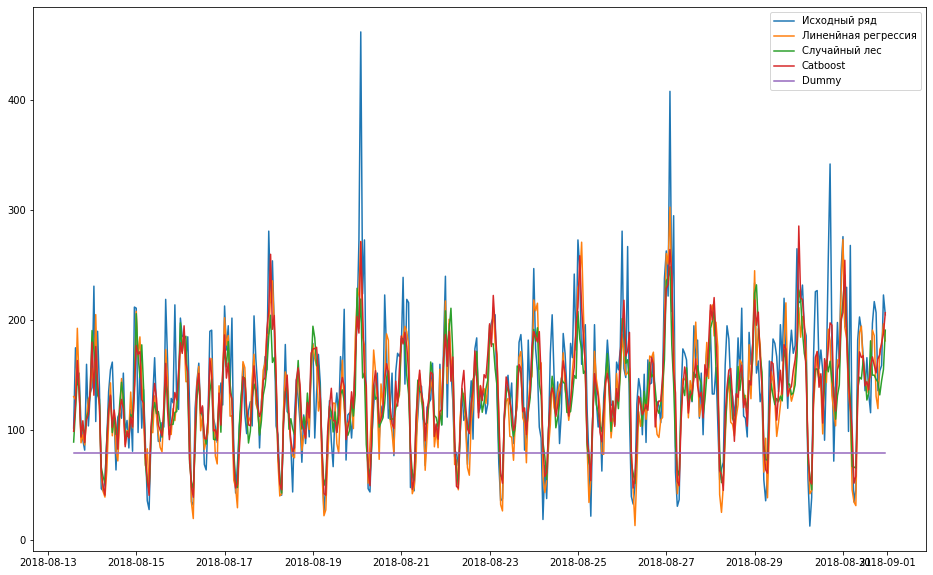

In [30]:
plt.figure(figsize=(16, 10))
plt.plot(test_y.index, test_y)
plt.plot(test_y.index, lr_test_pred)
plt.plot(test_y.index, rfr_test_pred)
plt.plot(test_y.index, cb_test_pred)
plt.plot(test_y.index, dummy_test_pred)
plt.legend(['Исходный ряд', 'Линенейная регрессия', 'Случайный лес', 'Catboost', 'Dummy'])
plt.show()